In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor  
from sklearn.svm import SVR

import mitosheet

In [3]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

In [4]:
results = []

### Unstructured Variance, n_input = 12, n_output = 1

In [5]:
df = pd.read_excel("Data/US15I1O.xlsx", index_col = 0)
df

,Input 01,Input 02,Input 03,Input 04,Input 05,Input 06,Input 07,Input 08,Input 09,Input 10,Input 11,Input 12,Input 13,Input 14,Input 15,Output 01
DMU 0001,275.46,50.34,340.07,198.33,252.31,152.33,171.94,351.93,99.92,276.03,521.97,377.73,182.73,323.82,149.79,604.61
DMU 0002,215.47,60.38,340.06,310.86,293.92,194.99,213.47,449.00,236.11,219.68,448.57,389.20,136.40,381.47,155.19,549.84
DMU 0003,300.23,64.11,340.12,309.33,318.17,150.53,158.62,260.07,220.55,198.77,347.80,180.49,143.57,314.84,152.35,374.89
DMU 0004,318.80,70.69,340.03,308.70,284.31,177.03,184.56,248.79,196.65,194.76,308.82,370.43,154.72,236.00,150.82,308.83
DMU 0005,308.48,76.50,340.03,300.18,320.88,186.92,207.32,311.17,217.06,213.73,369.79,371.99,140.98,334.56,153.16,478.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DMU 0996,229.84,62.77,340.10,307.80,251.16,170.90,181.09,345.93,209.08,206.03,420.21,324.91,145.44,267.75,152.00,434.69
DMU 0997,277.75,63.85,340.07,297.61,292.52,163.04,211.13,295.84,217.56,231.60,454.72,233.57,140.77,400.10,155.33,528.69
DMU 0998,245.12,44.22,340.05,310.36,284.72,157.20,154.61,341.60,168.51,281.86,383.23,351.73,166.37,259.97,151.17,448.42
DMU 0999,229.51,72.14,340.09,313.09,277.03,161.84,177.60,347.74,232.43,226.38,397.84,333.21,132.83,351.30,154.23,483.78


In [6]:
df_sol = pd.read_excel("US15I1O_gradientboostingregressor_Solution_3.xlsx", index_col = 0)[["Efficiency_Scores"]]
df_sol

,Efficiency_Scores
DMU 0001,0.832982
DMU 0002,0.720755
DMU 0003,0.711432
DMU 0004,0.553956
DMU 0005,0.720618
...,...
DMU 0996,0.682288
DMU 0997,0.803977
DMU 0998,0.719427
DMU 0999,0.721136


In [7]:
import mitosheet
mitosheet.sheet(df_sol, view_df=True)

MitoWidget(analysis_data_json='{"analysisName": "UUID-248d303e-d8ce-47f7-a497-5a6b48d4bb17", "code": {"imports…

In [8]:
df_weights = pd.read_excel("US15I1O_gradientboostingregressor_Solution_3.xlsx", index_col = 0).iloc[:, 1:]
df_weights

,Weight_Input 01,Weight_Input 02,Weight_Input 03,Weight_Input 04,Weight_Input 05,Weight_Input 06,Weight_Input 07,Weight_Input 08,Weight_Input 09,Weight_Input 10,Weight_Input 11,Weight_Input 12,Weight_Input 13,Weight_Input 14,Weight_Input 15,Weight_Output 01
DMU 0001,0.000119,0.000569,0.0,0.0,0.000119,0.0,0.0,0.000569,0.000119,0.0,0.000569,0.000569,0.0,0.000569,0.0,0.001378
DMU 0002,0.000291,0.000291,0.0,0.0,0.000000,0.0,0.0,0.000291,0.000000,0.0,0.000647,0.000647,0.0,0.000647,0.0,0.001311
DMU 0003,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000686,0.000000,0.0,0.000974,0.000974,0.0,0.000974,0.0,0.001898
DMU 0004,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000859,0.000000,0.0,0.000859,0.000859,0.0,0.000859,0.0,0.001794
DMU 0005,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000721,0.000000,0.0,0.000721,0.000721,0.0,0.000721,0.0,0.001505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DMU 0996,0.000227,0.000227,0.0,0.0,0.000000,0.0,0.0,0.000598,0.000000,0.0,0.000717,0.000717,0.0,0.000717,0.0,0.001570
DMU 0997,0.000246,0.000246,0.0,0.0,0.000000,0.0,0.0,0.000662,0.000000,0.0,0.000662,0.000662,0.0,0.000662,0.0,0.001521
DMU 0998,0.000208,0.000571,0.0,0.0,0.000000,0.0,0.0,0.000571,0.000000,0.0,0.000732,0.000732,0.0,0.000732,0.0,0.001604
DMU 0999,0.000215,0.000215,0.0,0.0,0.000000,0.0,0.0,0.000568,0.000000,0.0,0.000681,0.000681,0.0,0.000681,0.0,0.001491


In [9]:
df_zero =(df_weights==0).sum()
df_zero

Weight_Input 01     262
Weight_Input 02     203
Weight_Input 03     851
Weight_Input 04     917
Weight_Input 05     758
Weight_Input 06     924
Weight_Input 07     872
Weight_Input 08      11
Weight_Input 09     709
Weight_Input 10     819
Weight_Input 11       0
Weight_Input 12       3
Weight_Input 13     886
Weight_Input 14       0
Weight_Input 15     872
Weight_Output 01      0
dtype: int64

### ML

In [10]:
X = df
X.head()

,Input 01,Input 02,Input 03,Input 04,Input 05,Input 06,Input 07,Input 08,Input 09,Input 10,Input 11,Input 12,Input 13,Input 14,Input 15,Output 01
DMU 0001,275.46,50.34,340.07,198.33,252.31,152.33,171.94,351.93,99.92,276.03,521.97,377.73,182.73,323.82,149.79,604.61
DMU 0002,215.47,60.38,340.06,310.86,293.92,194.99,213.47,449.00,236.11,219.68,448.57,389.20,136.40,381.47,155.19,549.84
DMU 0003,300.23,64.11,340.12,309.33,318.17,150.53,158.62,260.07,220.55,198.77,347.80,180.49,143.57,314.84,152.35,374.89
DMU 0004,318.80,70.69,340.03,308.70,284.31,177.03,184.56,248.79,196.65,194.76,308.82,370.43,154.72,236.00,150.82,308.83
DMU 0005,308.48,76.50,340.03,300.18,320.88,186.92,207.32,311.17,217.06,213.73,369.79,371.99,140.98,334.56,153.16,478.87


In [11]:
y = df_sol
y.head()

,Efficiency_Scores
DMU 0001,0.832982
DMU 0002,0.720755
DMU 0003,0.711432
DMU 0004,0.553956
DMU 0005,0.720618


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

In [14]:
dt_model = DecisionTreeRegressor(random_state=42)

pipe_dt = make_pipeline(std_scaler, dt_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_dt, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.002818434880492349
neg_root_mean_squared_error: -0.053063830450593985
r2: 0.7555470441140686


In [15]:
# specify parameter values to search
params = {}
params['decisiontreeregressor__max_depth'] = list(range(1, 15))
params['decisiontreeregressor__min_samples_split'] = list(range(10, 60, 10))
params['decisiontreeregressor__max_features'] = ["auto","log2","sqrt",None]

In [16]:
grid = GridSearchCV(pipe_dt, params, cv=5, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'decisiontreeregressor__max_depth': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10, 11,
                                                              12, 13, 14],
                         'decisiontreeregressor__max_features': ['auto', 'log2',
                                                                 'sqrt', None],
                         'decisiontreeregressor__min_samples_split': [10, 20,
                                                                      30, 40,
                                                                      50]},
             scoring='neg_root_mean_squared_error')

In [17]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y, scoring="r2").mean())

-0.048537696850081136
{'decisiontreeregressor__max_depth': 12, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__min_samples_split': 20}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=12, max_features='auto',
                                       min_samples_split=20,
                                       random_state=42))])
r2: 0.7948008870787802


In [18]:
imp_dt = grid.best_estimator_.steps[1][1].feature_importances_
imp_dt

array([0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.06, 0.02, 0.  , 0.12, 0.  , 0.78])

In [19]:
#pipe_dt.fit(X, y)
#
#imp_dt = pipe_dt.steps[1][1].feature_importances_
#imp_dt

In [20]:
df_dt = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_dt}).sort_values("Importance", ascending=False)
df_dt

,Feature Name,Importance
15,Output 01,0.781449
13,Input 14,0.120362
10,Input 11,0.064607
11,Input 12,0.015614
7,Input 08,0.006505
...,...,...
4,Input 05,0.000000
6,Input 07,0.000000
8,Input 09,0.000000
9,Input 10,0.000000


In [21]:
input_imp = list(df_dt.loc[df_dt["Feature Name"].str.contains("Input"), "Feature Name"].values)
results.append((grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y, scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_}))

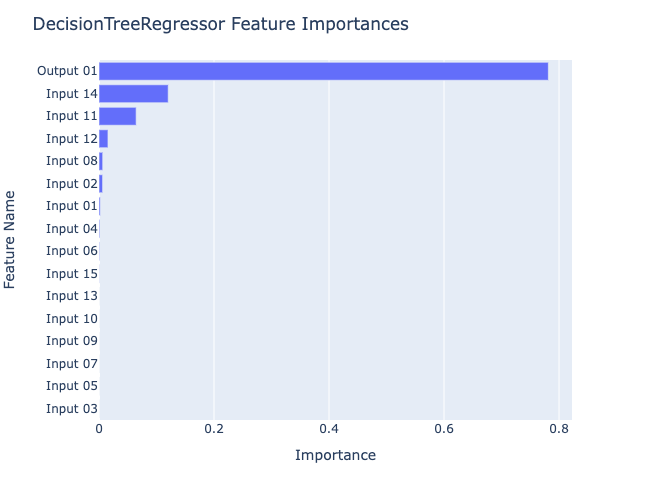

In [22]:
fig = px.bar(df_dt, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"DecisionTreeRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [23]:
df_zero.index = [f.split("_")[1] for f in df_zero.index]

In [24]:
df_merged = pd.merge(df_dt, df_zero.reset_index(), left_on="Feature Name", right_on="index")
df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
df_merged

,Feature Name,Importance,index,Zero_Count
0,Output 01,0.781449,Output 01,0
1,Input 14,0.120362,Input 14,0
2,Input 11,0.064607,Input 11,0
3,Input 12,0.015614,Input 12,3
4,Input 08,0.006505,Input 08,11
...,...,...,...,...
11,Input 05,0.000000,Input 05,758
12,Input 07,0.000000,Input 07,872
13,Input 09,0.000000,Input 09,709
14,Input 10,0.000000,Input 10,819


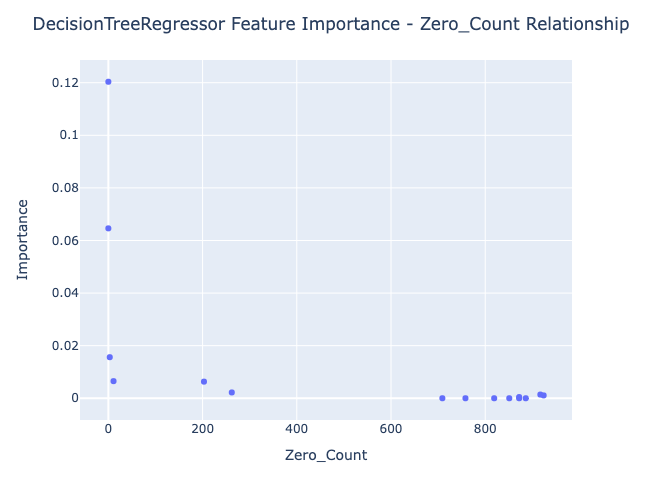

In [25]:
fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"DecisionTreeRegressor Feature Importance - Zero_Count Relationship",
)

fig.show()

In [26]:
rf_model = RandomForestRegressor(random_state=42)

pipe_rf = make_pipeline(std_scaler, rf_model)


# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.001217354102152302
neg_root_mean_squared_error: -0.03465778744347252
r2: 0.8953673844480257


In [27]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
print(n_estimators)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
print(max_depth)
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [28]:
# specify parameter values to search
params = {}
params['randomforestregressor__n_estimators'] = n_estimators
params['randomforestregressor__max_features'] = max_features
params['randomforestregressor__max_depth'] = max_depth
params['randomforestregressor__min_samples_split'] = min_samples_split
params['randomforestregressor__min_samples_leaf'] = min_samples_leaf
params['randomforestregressor__bootstrap'] = bootstrap

In [29]:
grid = RandomizedSearchCV(pipe_rf, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'randomforestregressor__bootstrap': [True,
                                                                             False],
                                        'randomforestregressor__max_depth': [10,
                                                                             20,
                                                                             30,
                                                                             40,
                                                                             50,
                                                                             60,
                                

In [30]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-0.03482416741622427
{'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100, 'randomforestregressor__bootstrap': True}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=2,
                                       n_estimators=800, random_state=42))])
r2: 0.8945299838295302


In [31]:
imp_rf = grid.best_estimator_.steps[1][1].feature_importances_
imp_rf

array([0.01, 0.01, 0.  , 0.  , 0.01, 0.  , 0.  , 0.01, 0.  , 0.  , 0.06, 0.02, 0.  , 0.12, 0.  , 0.74])

In [32]:
#pipe_rf.fit(X, y.values.ravel())
#
#imp_rf = pipe_rf.steps[1][1].feature_importances_

In [33]:
df_rf = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_rf}).sort_values("Importance", ascending=False)
df_rf

,Feature Name,Importance
15,Output 01,0.735191
13,Input 14,0.122075
10,Input 11,0.060993
11,Input 12,0.015678
7,Input 08,0.011623
...,...,...
5,Input 06,0.004267
14,Input 15,0.004038
8,Input 09,0.004020
6,Input 07,0.003766


In [34]:
input_imp = list(df_rf.loc[df_rf["Feature Name"].str.contains("Input"), "Feature Name"].values)
results.append((grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_}))

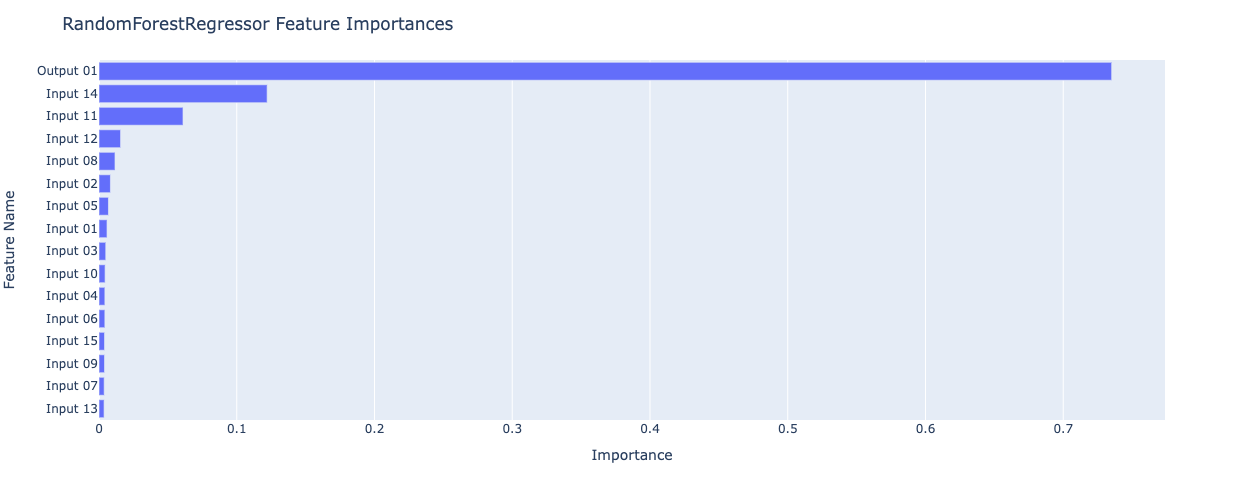

In [35]:
fig = px.bar(df_rf, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"RandomForestRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [36]:
df_merged = pd.merge(df_rf, df_zero.reset_index(), left_on="Feature Name", right_on="index")
df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
df_merged

,Feature Name,Importance,index,Zero_Count
0,Output 01,0.735191,Output 01,0
1,Input 14,0.122075,Input 14,0
2,Input 11,0.060993,Input 11,0
3,Input 12,0.015678,Input 12,3
4,Input 08,0.011623,Input 08,11
...,...,...,...,...
11,Input 06,0.004267,Input 06,924
12,Input 15,0.004038,Input 15,872
13,Input 09,0.004020,Input 09,709
14,Input 07,0.003766,Input 07,872


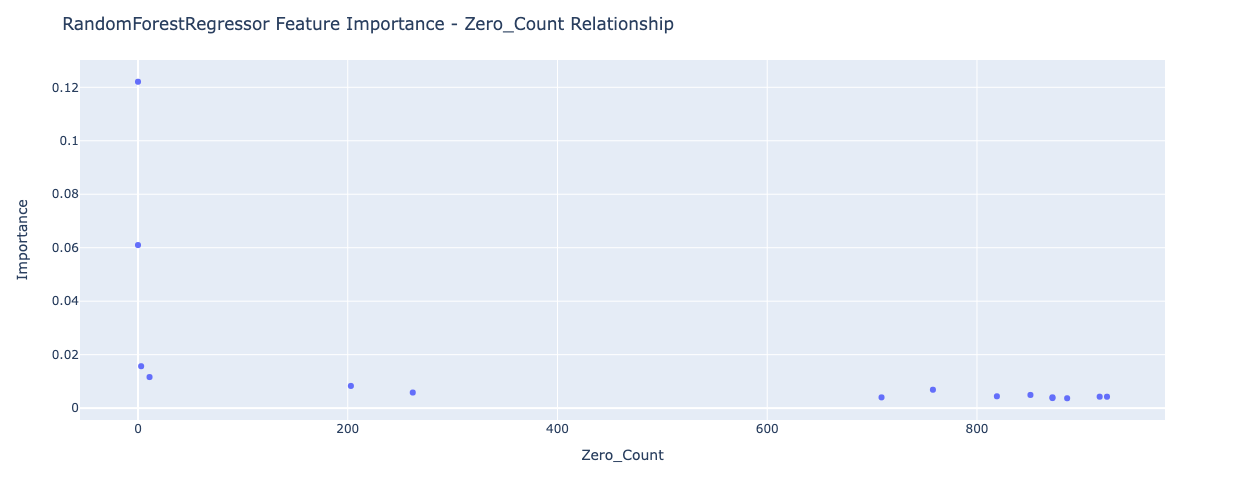

In [37]:
fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"RandomForestRegressor Feature Importance - Zero_Count Relationship",
)

fig.show()

In [38]:
gb_model = GradientBoostingRegressor(random_state=42)

pipe_gb = make_pipeline(std_scaler, gb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0007332671685302187
neg_root_mean_squared_error: -0.026874470349638246
r2: 0.9369108032361695


In [39]:
#learning_rate = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
#n_estimators = [200, 500, 1000, 2000]
#max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
#print(max_depth)
#max_depth.append(None)
## Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
## Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]

In [40]:
learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

In [41]:
# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

In [42]:
grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('gradientboostingregressor',
                                              GradientBoostingRegressor(random_state=42))]),
                   param_distributions={'gradientboostingregressor__learning_rate': [1,
                                                                                     0.5,
                                                                                     0.1,
                                                                                     0.01],
                                        'gradientboostingregressor__max_depth': [3,
                                                                                 5,
                                                                                 10,
                                                                 

In [43]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-0.01863955775814779
{'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, min_samples_leaf=2,
                                           min_samples_split=30,
                                           n_estimators=500, random_state=42,
                                           subsample=0.3))])
r2: 0.9693579638779614


In [44]:
imp_gb = grid.best_estimator_.steps[1][1].feature_importances_
imp_gb

array([0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.01, 0.  , 0.08, 0.03, 0.  , 0.16, 0.  , 0.65])

In [45]:
#pip_gb.fit(X, y.values.ravel())
#
#imp_gb = pip_gb.steps[1][1].feature_importances_

In [46]:
df_gb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_gb}).sort_values("Importance", ascending=False)
df_gb

,Feature Name,Importance
15,Output 01,0.653924
13,Input 14,0.164187
10,Input 11,0.079823
11,Input 12,0.029680
7,Input 08,0.020654
...,...,...
4,Input 05,0.003859
6,Input 07,0.003463
12,Input 13,0.003360
3,Input 04,0.003064


In [47]:
input_imp = list(df_gb.loc[df_gb["Feature Name"].str.contains("Input"), "Feature Name"].values)
results.append((grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_}))

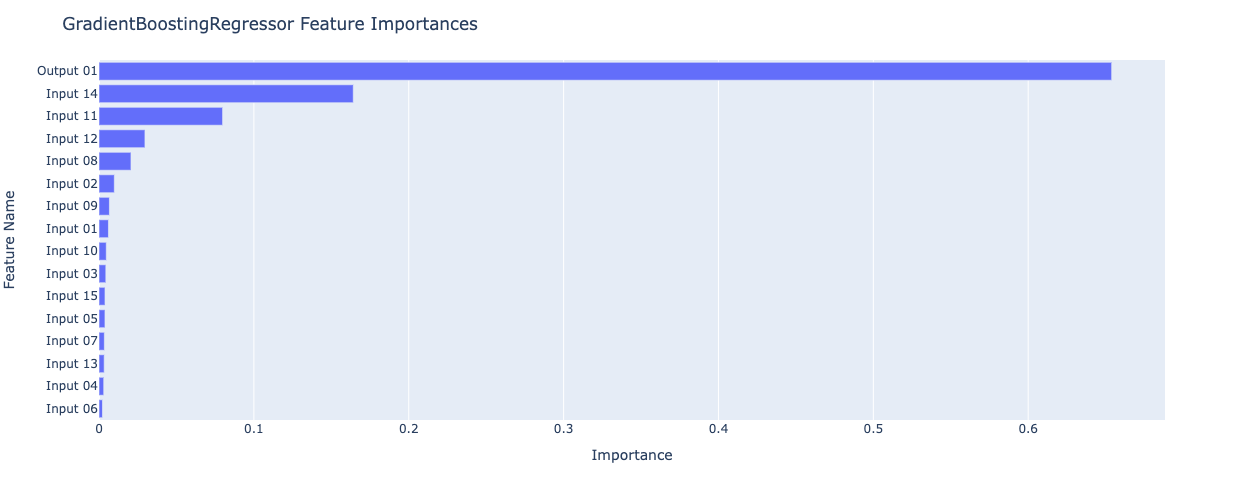

In [48]:
fig = px.bar(df_gb, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"GradientBoostingRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [49]:
df_merged = pd.merge(df_gb, df_zero.reset_index(), left_on="Feature Name", right_on="index")
df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
df_merged

,Feature Name,Importance,index,Zero_Count
0,Output 01,0.653924,Output 01,0
1,Input 14,0.164187,Input 14,0
2,Input 11,0.079823,Input 11,0
3,Input 12,0.029680,Input 12,3
4,Input 08,0.020654,Input 08,11
...,...,...,...,...
11,Input 05,0.003859,Input 05,758
12,Input 07,0.003463,Input 07,872
13,Input 13,0.003360,Input 13,886
14,Input 04,0.003064,Input 04,917


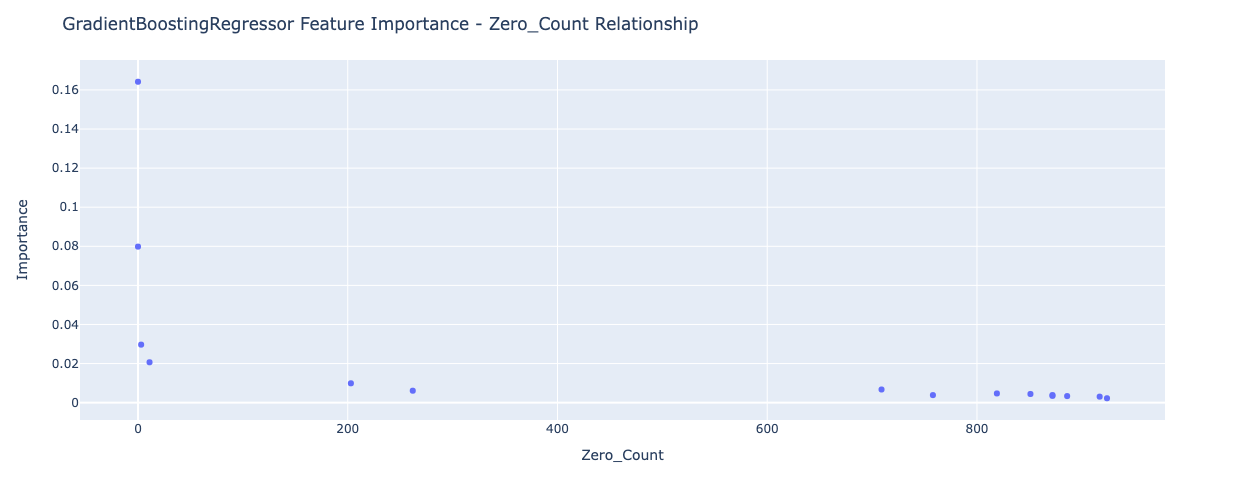

In [50]:
fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"GradientBoostingRegressor Feature Importance - Zero_Count Relationship",
)

fig.show()

In [51]:
model = grid.best_estimator_.fit(X_train, y_train.values.ravel())
prediction = model.predict(X_test)

In [52]:
res = pd.DataFrame()
res["Prediction"] = pd.Series(prediction.ravel())
res["Actual"] = y_test.values
res["Diff"] = res.Prediction - res.Actual
res["Error_Perc"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
res["Error_Perc < 3"] = np.abs(res["Error_Perc"]) < 3  
res = res.round(4)
res.index = X_test.index
res

,Prediction,Actual,Diff,Error_Perc,Error_Perc < 3
DMU 0522,0.6279,0.6214,0.0065,1.0448,True
DMU 0738,0.7906,0.7909,-0.0003,-0.0387,True
DMU 0741,0.7834,0.7855,-0.0021,-0.2674,True
DMU 0661,0.8351,0.8326,0.0025,0.2944,True
DMU 0412,0.7910,0.7870,0.0040,0.5059,True
...,...,...,...,...,...
DMU 0409,0.8273,0.8156,0.0117,1.4341,True
DMU 0333,0.7664,0.7687,-0.0024,-0.3108,True
DMU 0209,0.5649,0.5883,-0.0234,-3.9773,False
DMU 0614,0.8399,1.0000,-0.1601,-16.0120,False


In [53]:
blue = res["Error_Perc < 3"].sum()
print(blue)
red = len(res["Error_Perc < 3"]) - (res["Error_Perc < 3"].sum())
red

165


35

In [54]:
rho, p = stats.spearmanr(res.Prediction, res.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9884
p-Value 0.0


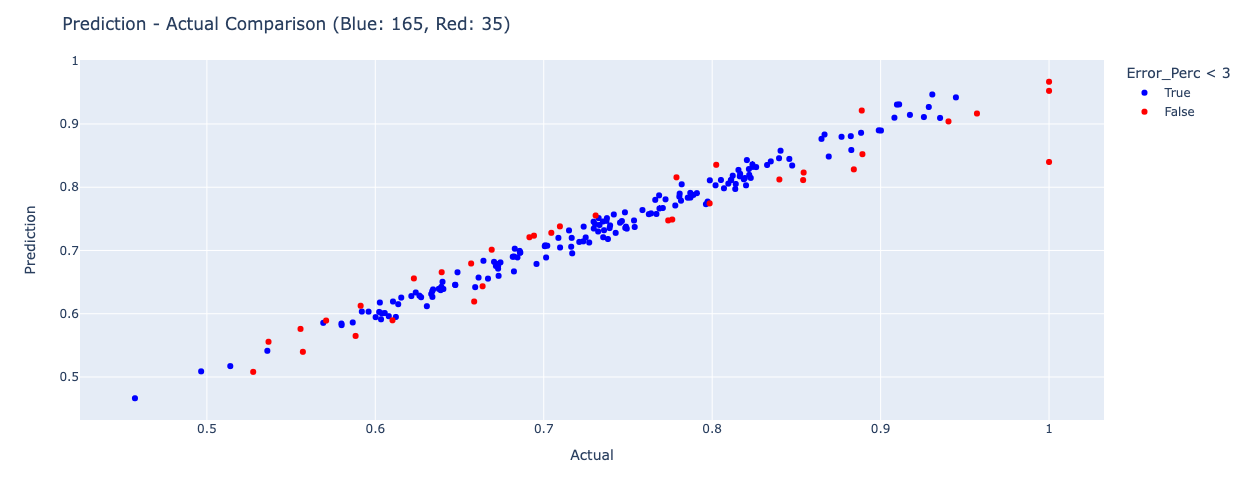

In [55]:
fig = px.scatter(res.reset_index().rename(columns={'index': 'DMU'}), x="Actual", y="Prediction", color = "Error_Perc < 3", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Perc", "DMU"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

In [56]:
xgb_model = xgb.XGBRegressor(random_state=42)

pipe_xgb = make_pipeline(std_scaler, xgb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0009230566919713341
neg_root_mean_squared_error: -0.029945547487319125
r2: 0.9209373497254664


In [57]:
# xgb.plot_tree(xgb_model,num_trees=0)
# plt.rcParams['figure.figsize'] = [50, 10]
# plt.show()

In [58]:
learning_rate = [0.01, 0.1, 0.2, 0.3]
n_estimators = [100, 500, 1000]
max_depth =  [3, 5, 6, 10, 15, 20]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)

In [59]:
# specify parameter values to search
params = {}
params['xgbregressor__learning_rate'] = learning_rate
params['xgbregressor__n_estimators'] = n_estimators
params['xgbregressor__max_depth'] = max_depth
params['xgbregressor__subsample'] = subsample
params['xgbregressor__colsample_bytree'] = colsample_bytree
params['xgbregressor__colsample_bylevel'] = colsample_bylevel

In [60]:
grid = RandomizedSearchCV(pipe_xgb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('xgbregressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           enable_categorical=False,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           importance_type=None,
                                                           interaction_constrai

In [61]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-0.03067798812399669
{'xgbregressor__subsample': 0.5, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__colsample_bylevel': 0.7999999999999999}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.7999999999999999,
                              colsample_bynode=1, colsample_bytree=0.7,
                              enable_categorical=False, gamma=0, gpu_id=-1,
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_delta_step=0, max_depth=6,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=500,
                              n_jobs=8, num_parallel_tree=1, predictor='auto',
       

In [62]:
imp_xgb = grid.best_estimator_.steps[1][1].feature_importances_
imp_xgb

array([0.02, 0.02, 0.02, 0.03, 0.03, 0.02, 0.02, 0.03, 0.04, 0.06, 0.07, 0.08, 0.03, 0.1 , 0.02, 0.41], dtype=float32)

In [63]:
df_xgb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_xgb}).sort_values("Importance", ascending=False)
df_xgb

,Feature Name,Importance
15,Output 01,0.409694
13,Input 14,0.095549
11,Input 12,0.084315
10,Input 11,0.066269
9,Input 10,0.062576
...,...,...
5,Input 06,0.021174
2,Input 03,0.020302
14,Input 15,0.019997
0,Input 01,0.019648


In [64]:
input_imp = list(df_xgb.loc[df_xgb["Feature Name"].str.contains("Input"), "Feature Name"].values)
results.append((grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_}))

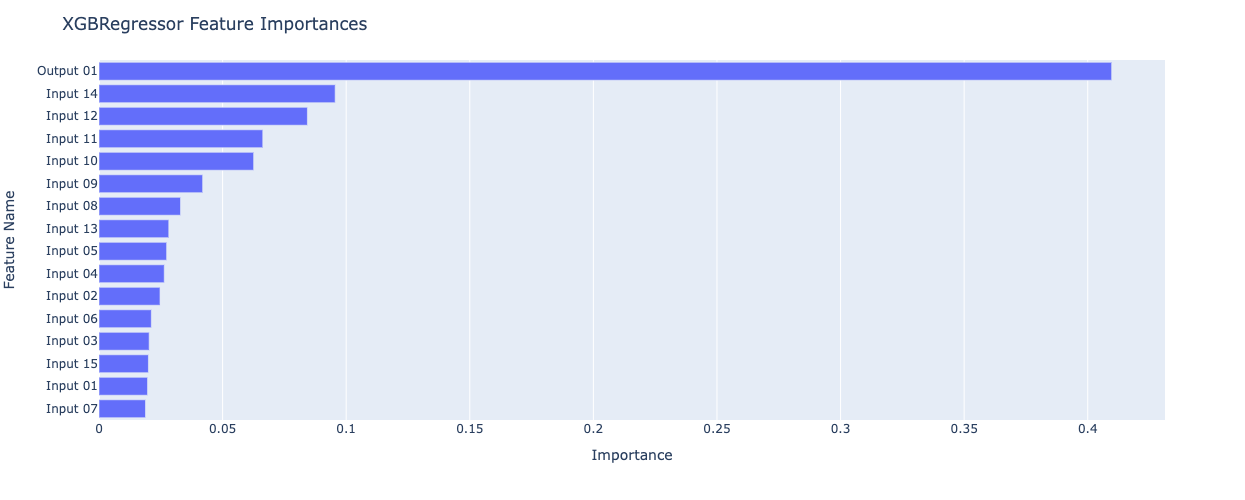

In [65]:
fig = px.bar(df_xgb, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"XGBRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [66]:
df_merged = pd.merge(df_xgb, df_zero.reset_index(), left_on="Feature Name", right_on="index")
df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
df_merged

,Feature Name,Importance,index,Zero_Count
0,Output 01,0.409694,Output 01,0
1,Input 14,0.095549,Input 14,0
2,Input 12,0.084315,Input 12,3
3,Input 11,0.066269,Input 11,0
4,Input 10,0.062576,Input 10,819
...,...,...,...,...
11,Input 06,0.021174,Input 06,924
12,Input 03,0.020302,Input 03,851
13,Input 15,0.019997,Input 15,872
14,Input 01,0.019648,Input 01,262


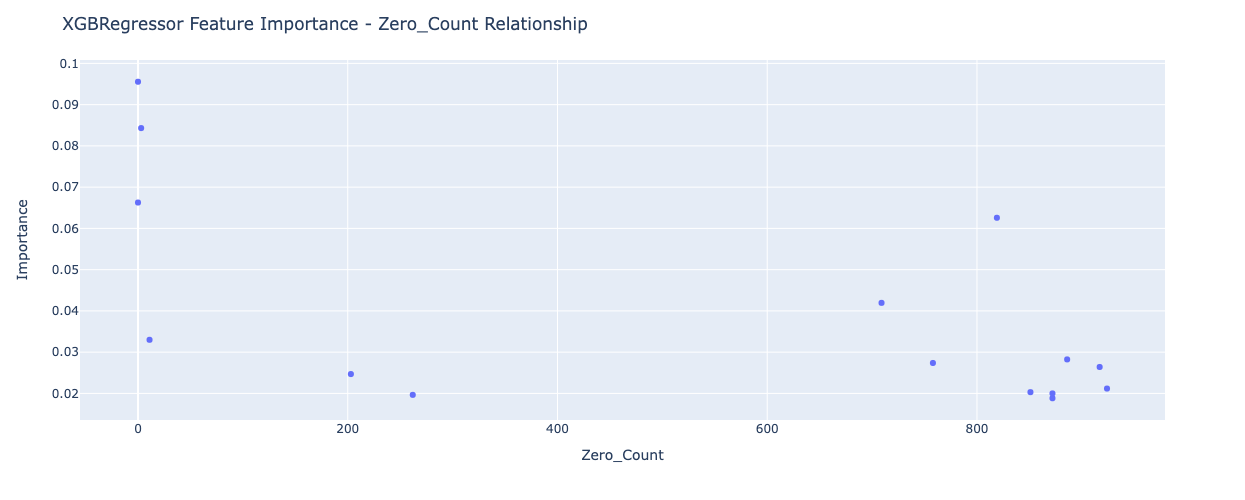

In [67]:
fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"XGBRegressor Feature Importance - Zero_Count Relationship",
)

fig.show()

In [68]:
pipe_xgb.fit(X, y.values.ravel())

pipe_xgb.steps[1][1].feature_importances_

array([0.  , 0.01, 0.01, 0.  , 0.01, 0.  , 0.  , 0.02, 0.  , 0.  , 0.06, 0.02, 0.  , 0.13, 0.  , 0.73], dtype=float32)

In [69]:
pipe_xgb.steps[1][1].get_booster().get_score(importance_type='cover')

{'f0': 83.25,
 'f1': 87.03157806396484,
 'f2': 81.33858489990234,
 'f3': 72.3553695678711,
 'f4': 162.16567993164062,
 'f5': 119.77848052978516,
 'f6': 168.3111114501953,
 'f7': 161.32240295410156,
 'f8': 97.45454406738281,
 'f9': 200.0719451904297,
 'f10': 189.292236328125,
 'f11': 217.6855926513672,
 'f12': 222.56382751464844,
 'f13': 222.76666259765625,
 'f14': 255.41525268554688,
 'f15': 275.4398498535156}

In [70]:
plt.rcParams['figure.figsize'] = [12, 10]

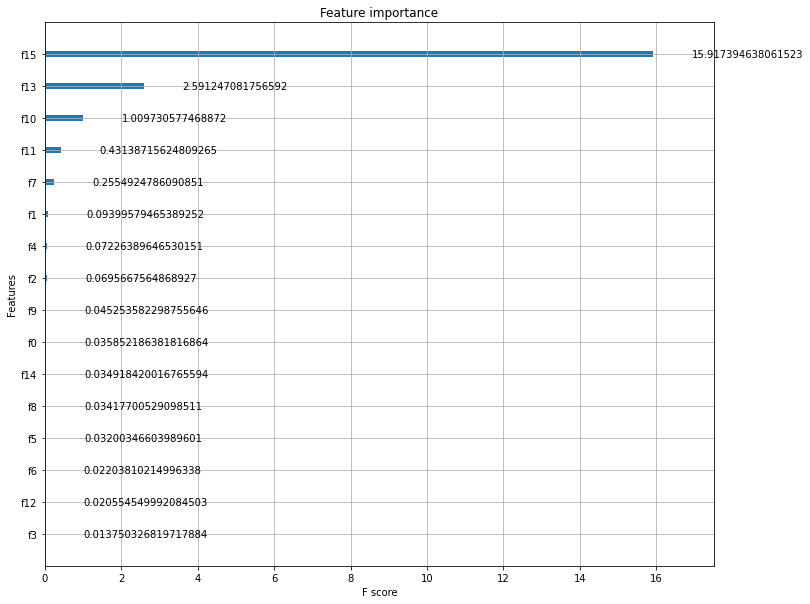

In [71]:
xgb.plot_importance(pipe_xgb.steps[1][1]._Booster, importance_type='total_gain')
plt.show()

In [72]:
results

[('decisiontreeregressor',
  ['Input 14',
   'Input 11',
   'Input 12',
   'Input 08',
   'Input 02',
   'Input 01',
   'Input 04',
   'Input 06',
   'Input 15',
   'Input 03',
   'Input 05',
   'Input 07',
   'Input 09',
   'Input 10',
   'Input 13'],
  {'r2': 0.7948008870787802,
   'neg_root_mean_squared_error': -0.048537696850081136}),
 ('randomforestregressor',
  ['Input 14',
   'Input 11',
   'Input 12',
   'Input 08',
   'Input 02',
   'Input 05',
   'Input 01',
   'Input 03',
   'Input 10',
   'Input 04',
   'Input 06',
   'Input 15',
   'Input 09',
   'Input 07',
   'Input 13'],
  {'r2': 0.8945299838295302,
   'neg_root_mean_squared_error': -0.03482416741622427}),
 ('gradientboostingregressor',
  ['Input 14',
   'Input 11',
   'Input 12',
   'Input 08',
   'Input 02',
   'Input 09',
   'Input 01',
   'Input 10',
   'Input 03',
   'Input 15',
   'Input 05',
   'Input 07',
   'Input 13',
   'Input 04',
   'Input 06'],
  {'r2': 0.9693579638779614,
   'neg_root_mean_squared_error':

In [73]:
with open('result_15I1O_4.pkl', 'wb') as f:
    pickle.dump(results, f)

In [74]:
with open('result_15I1O_4.pkl', 'rb') as f:
    r = pickle.load(f)

In [75]:
r

[('decisiontreeregressor',
  ['Input 14',
   'Input 11',
   'Input 12',
   'Input 08',
   'Input 02',
   'Input 01',
   'Input 04',
   'Input 06',
   'Input 15',
   'Input 03',
   'Input 05',
   'Input 07',
   'Input 09',
   'Input 10',
   'Input 13'],
  {'r2': 0.7948008870787802,
   'neg_root_mean_squared_error': -0.048537696850081136}),
 ('randomforestregressor',
  ['Input 14',
   'Input 11',
   'Input 12',
   'Input 08',
   'Input 02',
   'Input 05',
   'Input 01',
   'Input 03',
   'Input 10',
   'Input 04',
   'Input 06',
   'Input 15',
   'Input 09',
   'Input 07',
   'Input 13'],
  {'r2': 0.8945299838295302,
   'neg_root_mean_squared_error': -0.03482416741622427}),
 ('gradientboostingregressor',
  ['Input 14',
   'Input 11',
   'Input 12',
   'Input 08',
   'Input 02',
   'Input 09',
   'Input 01',
   'Input 10',
   'Input 03',
   'Input 15',
   'Input 05',
   'Input 07',
   'Input 13',
   'Input 04',
   'Input 06'],
  {'r2': 0.9693579638779614,
   'neg_root_mean_squared_error':

In [76]:
ft_imp  = df_dt.set_index("Feature Name").join(df_rf.set_index("Feature Name"), rsuffix="_rf").join(df_gb.set_index("Feature Name"), rsuffix="_gb").join(df_xgb.set_index("Feature Name"), rsuffix="_xgb")
ft_imp

,Importance,Importance_rf,Importance_gb,Importance_xgb
Feature Name,,,,
Output 01,0.781449,0.735191,0.653924,0.409694
Input 14,0.120362,0.122075,0.164187,0.095549
Input 11,0.064607,0.060993,0.079823,0.066269
Input 12,0.015614,0.015678,0.029680,0.084315
Input 08,0.006505,0.011623,0.020654,0.032995
...,...,...,...,...
Input 05,0.000000,0.006877,0.003859,0.027375
Input 07,0.000000,0.003766,0.003463,0.018826
Input 09,0.000000,0.004020,0.006727,0.041948


In [77]:
ft_imp.to_excel("Data/US15I1O_ft_imp_4.xlsx")